In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Constants
MaxTimeLag = 5  # Maximum time allowed between two button presses.

# Generating Data
players = 50
levels = [1, 2, 3, 4]
plays_per_level = 3  # Number of times a player plays a level

data = {
    'PlayerID': [], 'GameID': [], 'Level': [], 'PlayNumber': [], 'ButtonSequence': [], 
    'PlayerButtonSequence': [], 'TimeBetweenPresses': [], 'Accuracy': [], 'Termination': []
}

game_id = 1000
for player in range(1, players+1):
    for level in levels:
        for play in range(1, plays_per_level + 1):
            termination_flag = False
            time_between_presses = [random.randint(1, 4) for _ in range(level * 3 - 2)]
            
            if MaxTimeLag in time_between_presses:
                termination_flag = True
                terminate_index = time_between_presses.index(MaxTimeLag)
            
            data['PlayerID'].append(player)
            data['GameID'].append(game_id)
            game_id += 1
            data['Level'].append(level)
            data['PlayNumber'].append(play)
            
            # Different levels with increasing difficulty
            if level == 1:
                button_seq = [(1,1), (1,2), (1,3)]
            elif level == 2:
                button_seq = [(1,4), (2,2), (2,4), (3,1), (3,3)]
            elif level == 3:
                button_seq = [(4,4), (5,2), (5,5), (6,1), (6,3), (7,2), (7,4)]
            else:
                button_seq = [(random.randint(1, 8), random.randint(1, 8)) for _ in range(10)]
            
            data['ButtonSequence'].append(button_seq)
            
            # Simulating player performance
            alteration = int(level * 0.2 * len(button_seq))
            player_seq = button_seq[:len(button_seq) - alteration] + [(random.randint(1, 8), random.randint(1, 8)) for _ in range(alteration)]
            
            if termination_flag:
                player_seq = player_seq[:terminate_index]
            
            data['PlayerButtonSequence'].append(player_seq)
            data['TimeBetweenPresses'].append(time_between_presses)
            
            correct_presses = len(set(button_seq).intersection(set(player_seq)))
            accuracy = (correct_presses / len(button_seq)) * 100
            data['Accuracy'].append(accuracy)
            data['Termination'].append(termination_flag)

df = pd.DataFrame(data)


In [3]:
print(df)

     PlayerID  GameID  Level  PlayNumber  \
0           1    1000      1           1   
1           1    1001      1           2   
2           1    1002      1           3   
3           1    1003      2           1   
4           1    1004      2           2   
..        ...     ...    ...         ...   
595        50    1595      3           2   
596        50    1596      3           3   
597        50    1597      4           1   
598        50    1598      4           2   
599        50    1599      4           3   

                                        ButtonSequence  \
0                             [(1, 1), (1, 2), (1, 3)]   
1                             [(1, 1), (1, 2), (1, 3)]   
2                             [(1, 1), (1, 2), (1, 3)]   
3             [(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]   
4             [(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]   
..                                                 ...   
595  [(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2...   
596  [(

In [4]:
# Get the last play for each player for each level
df_last_play = df[df.groupby(['PlayerID', 'Level'])['PlayNumber'].transform(max) == df['PlayNumber']]

# Prepare training data
df_last_play['ShiftedAccuracy'] = df_last_play.groupby('PlayerID')['Accuracy'].shift(-1)
df_training = df_last_play[df_last_play['Level'] < 4].dropna(subset=['ShiftedAccuracy'])

X_train = df_training[['Level', 'Accuracy']]
y_train = df_training['ShiftedAccuracy']

# Train a linear regression model
model = LinearRegression().fit(X_train, y_train)

# Predicting for next level
df_last_play['PredictedAccuracy'] = model.predict(df_last_play[['Level', 'Accuracy']])

/tmp/ipykernel_32/3284252197.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_play['ShiftedAccuracy'] = df_last_play.groupby('PlayerID')['Accuracy'].shift(-1)
/tmp/ipykernel_32/3284252197.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_play['PredictedAccuracy'] = model.predict(df_last_play[['Level', 'Accuracy']])


In [5]:
predicted = model.predict(X_train)
mse = mean_squared_error(y_train, predicted)
print(f"Mean Squared Error of Prediction Model: {mse:.2f}")

Mean Squared Error of Prediction Model: 47.43


In [6]:
def label_accuracy(accuracy):
    if accuracy > 90:
        return 'A'
    elif accuracy > 70:
        return 'B'
    else:
        return 'C'

df_last_play['Label'] = df_last_play['Accuracy'].apply(label_accuracy)

/tmp/ipykernel_32/3123311384.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_play['Label'] = df_last_play['Accuracy'].apply(label_accuracy)


In [7]:
df_last_play['Rank'] = df_last_play.groupby('Level')['Accuracy'].rank(ascending=False)

/tmp/ipykernel_32/3405398145.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_play['Rank'] = df_last_play.groupby('Level')['Accuracy'].rank(ascending=False)


In [8]:
# 1. Accuracy is already in the 'Accuracy' column

# 2. Calculate average time between presses for each game
df['AvgTimeBetweenPress'] = df['TimeBetweenPresses'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)

# 3. Calculate total time taken for each game
df['TotalTime'] = df['TimeBetweenPresses'].apply(sum)

# 4. Ranking based on accuracy for each game
df['Rank'] = df.groupby(['Level', 'PlayNumber'])['Accuracy'].rank(ascending=False, method='min')

# Displaying the data
display_columns = ['PlayerID', 'GameID', 'Level', 'PlayNumber', 'Accuracy', 'AvgTimeBetweenPress', 'TotalTime', 'Rank']
df_display = df[display_columns].sort_values(by=['GameID', 'Rank'])

# If you want to display only the first 10 rows:
df_display_head = df_display.head(10)
df_display_head


,PlayerID,GameID,Level,PlayNumber,Accuracy,AvgTimeBetweenPress,TotalTime,Rank
0,1,1000,1,1,100.000000,1.000000,1,1.0
1,1,1001,1,2,100.000000,1.000000,1,1.0
2,1,1002,1,3,100.000000,1.000000,1,1.0
3,1,1003,2,1,60.000000,2.000000,8,4.0
4,1,1004,2,2,60.000000,3.000000,12,6.0
5,1,1005,2,3,60.000000,2.500000,10,2.0
6,1,1006,3,1,42.857143,2.428571,17,10.0
7,1,1007,3,2,42.857143,3.285714,23,14.0
8,1,1008,3,3,57.142857,2.571429,18,2.0
9,1,1009,4,1,30.000000,2.500000,25,8.0


In [9]:
!pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
sns.set_style("darkgrid")

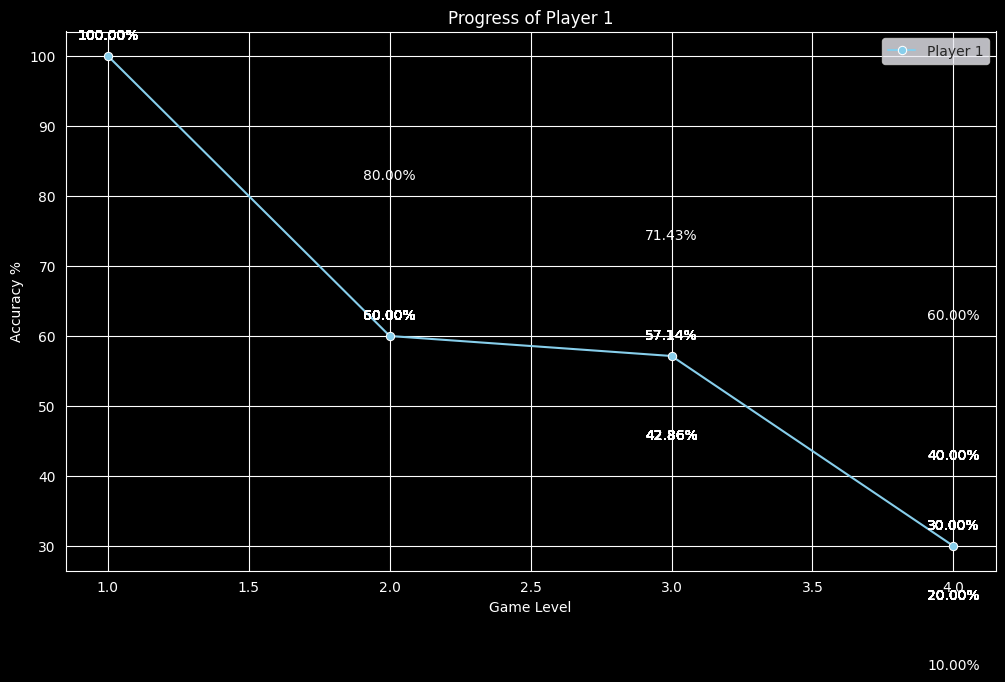

In [11]:
def plot_player_progress(player_id, dataframe):
    plt.figure(figsize=(12,7), facecolor='black')
    
    line = sns.lineplot(data=dataframe[dataframe['PlayerID'] == player_id], x='Level', y='Accuracy', color="skyblue", marker="o", label=f'Player {player_id}')
    
    # Annotating data points with their values
    for x, y in zip(dataframe['Level'], dataframe['Accuracy']):
        line.text(x, y+2, f'{y:.2f}%', color='white', ha="center", va="bottom")
    
    plt.title(f"Progress of Player {player_id}", color='white')
    plt.ylabel("Accuracy %", color='white')
    plt.xlabel("Game Level", color='white')
    plt.tick_params(colors='white', which='both')
    plt.gca().spines['left'].set_color('white')
    plt.gca().spines['bottom'].set_color('white')
    plt.gca().set_facecolor('black')
    plt.legend()
    plt.show()

# Test the function
plot_player_progress(1, df_last_play)

/tmp/ipykernel_32/202444964.py:7: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.
This will become an error in seaborn v0.13.0; please update your code.

  ax = sns.kdeplot(all_players['Accuracy'], fill=True, cmap='Blues_r', label='All Players', shade_lowest=True, color="dodgerblue")


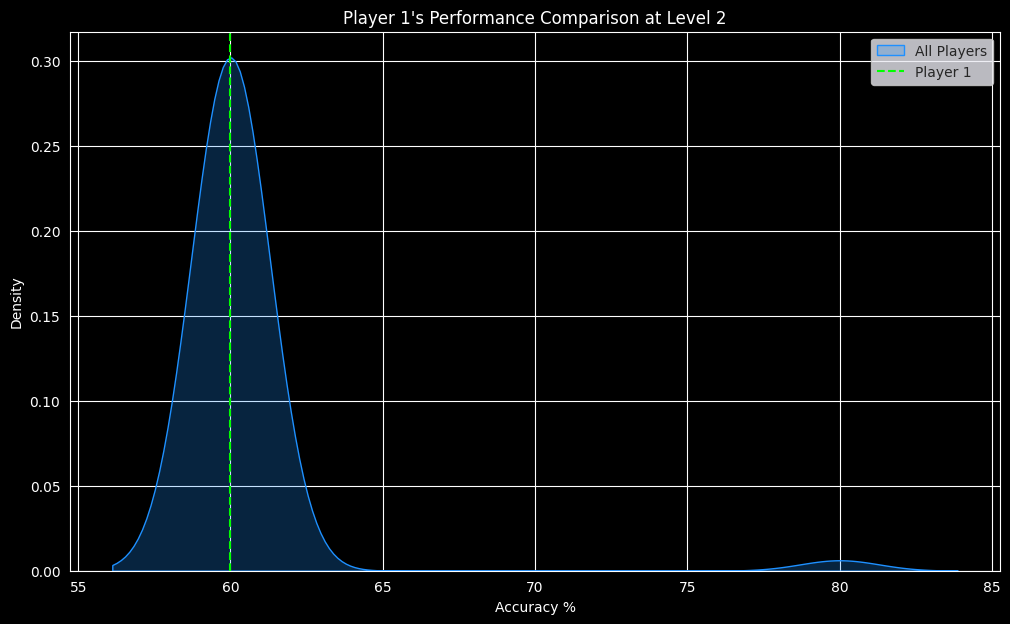

In [12]:
def plot_comparison_with_others_kde(player_id, dataframe, level):
    plt.figure(figsize=(12,7), facecolor='black')
    
    all_players = dataframe[dataframe['Level'] == level]
    
    # KDE plot with gradient fill in a brighter blue
    ax = sns.kdeplot(all_players['Accuracy'], fill=True, cmap='Blues_r', label='All Players', shade_lowest=True, color="dodgerblue")
    
    # Highlighting the specific player's accuracy for that level with a neon green color
    player_accuracy = dataframe[(dataframe['PlayerID'] == player_id) & (dataframe['Level'] == level)]['Accuracy'].values[0]
    plt.axvline(player_accuracy, color='lime', linestyle='dashed', linewidth=1.5, label=f'Player {player_id}')
    
    plt.title(f"Player {player_id}'s Performance Comparison at Level {level}", color='white')
    plt.ylabel("Density", color='white')
    plt.xlabel("Accuracy %", color='white')
    plt.tick_params(colors='white', which='both')
    plt.gca().spines['left'].set_color('white')
    plt.gca().spines['bottom'].set_color('white')
    plt.gca().set_facecolor('black')
    plt.legend()
    plt.show()

# Test the function
plot_comparison_with_others_kde(1, df_last_play, 2)

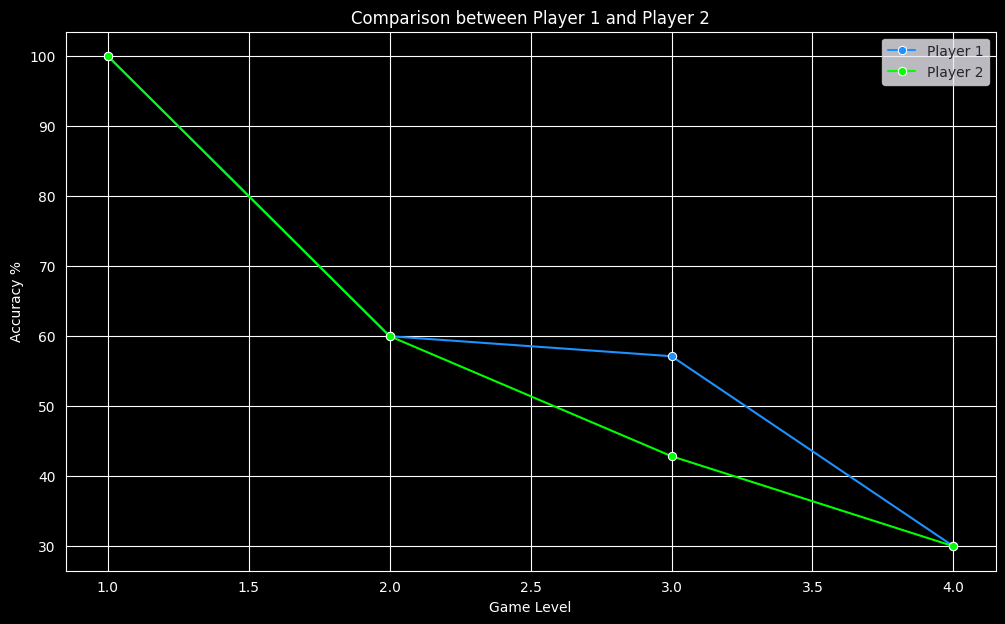

In [13]:
def plot_player_comparison(player1_id, player2_id, dataframe):
    plt.figure(figsize=(12,7), facecolor='black')
    
    data_player1 = dataframe[dataframe['PlayerID'] == player1_id]
    data_player2 = dataframe[dataframe['PlayerID'] == player2_id]
    
    sns.lineplot(data=data_player1, x='Level', y='Accuracy', color="dodgerblue", marker="o", label=f'Player {player1_id}')
    sns.lineplot(data=data_player2, x='Level', y='Accuracy', color="lime", marker="o", label=f'Player {player2_id}')
    
    plt.title(f"Comparison between Player {player1_id} and Player {player2_id}", color='white')
    plt.ylabel("Accuracy %", color='white')
    plt.xlabel("Game Level", color='white')
    plt.tick_params(colors='white', which='both')
    plt.gca().spines['left'].set_color('white')
    plt.gca().spines['bottom'].set_color('white')
    plt.gca().set_facecolor('black')
    plt.legend()
    plt.show()

# Test the function
plot_player_comparison(1, 2, df_last_play)

In [23]:
import pandas as pd
import random

# ... [Same constants and function definitions as before]

# Generating game data
def generate_game_data(seed):
    random.seed(seed)  # Using seed for reproducibility between different tables
    # ... [rest of the game data generation code]
    df = pd.DataFrame(data)
    return df

# Function to add AvgTimeBetweenPress and TotalTime columns
def compute_time_metrics(df):
    # Calculate average time between presses for each game
    df['AvgTimeBetweenPress'] = df['TimeBetweenPresses'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
    # Calculate total time taken for each game
    df['TotalTime'] = df['TimeBetweenPresses'].apply(sum)
    return df

# Creating four game tables
df1 = compute_time_metrics(generate_game_data(1))
df2 = compute_time_metrics(generate_game_data(2))
df3 = compute_time_metrics(generate_game_data(3))
df4 = compute_time_metrics(generate_game_data(4))

# Display top rows of each game table
df1.head(), df2.head(), df3.head(), df4.head()

from IPython.display import display, HTML

# Function to display a dataframe with a title in a scrollable div
def display_with_title(df, title, max_height="200px"):
    styled = df.style.set_table_attributes("style='display:inline;'").set_caption(title)
    scrollable_table = f"""
    <div style="max-height: {max_height}; overflow-y: auto;">
        {styled.to_html()}
    </div>
    """
    display(HTML(scrollable_table))

# Display each dataframe
display_with_title(df1.head(20), 'Game Table 1')
display_with_title(df2.head(20), 'Game Table 2')
display_with_title(df3.head(20), 'Game Table 3')
display_with_title(df4.head(20), 'Game Table 4')


,PlayerID,GameID,Level,PlayNumber,ButtonSequence,PlayerButtonSequence,TimeBetweenPresses,Accuracy,Termination,AvgTimeBetweenPress,TotalTime
0,1,1000,1,1,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
1,1,1001,1,2,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
2,1,1002,1,3,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
3,1,1003,2,1,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (7, 7), (2, 6)]","[1, 2, 3, 2]",60.000000,False,2.000000,8
4,1,1004,2,2,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (2, 4), (5, 6)]","[2, 3, 3, 4]",60.000000,False,3.000000,12
5,1,1005,2,3,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (6, 5), (4, 8)]","[1, 4, 4, 1]",60.000000,False,2.500000,10
6,1,1006,3,1,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (1, 6), (8, 3), (1, 7), (5, 1)]","[3, 2, 1, 3, 4, 3, 1]",42.857143,False,2.428571,17
7,1,1007,3,2,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (8, 6), (1, 5), (5, 7), (1, 2)]","[4, 4, 4, 3, 3, 2, 3]",42.857143,False,3.285714,23
8,1,1008,3,3,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (3, 4), (3, 4), (3, 6), (7, 2)]","[2, 3, 2, 4, 2, 4, 1]",57.142857,False,2.571429,18
9,1,1009,4,1,"[(2, 7), (7, 6), (8, 5), (5, 5), (6, 2), (3, 2), (4, 5), (2, 3), (2, 5), (3, 4)]","[(2, 7), (7, 6), (6, 3), (7, 4), (6, 5), (2, 3), (3, 5), (5, 3), (8, 4), (8, 3)]","[4, 1, 2, 4, 1, 3, 4, 1, 1, 4]",30.000000,False,2.500000,25


,PlayerID,GameID,Level,PlayNumber,ButtonSequence,PlayerButtonSequence,TimeBetweenPresses,Accuracy,Termination,AvgTimeBetweenPress,TotalTime
0,1,1000,1,1,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
1,1,1001,1,2,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
2,1,1002,1,3,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
3,1,1003,2,1,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (7, 7), (2, 6)]","[1, 2, 3, 2]",60.000000,False,2.000000,8
4,1,1004,2,2,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (2, 4), (5, 6)]","[2, 3, 3, 4]",60.000000,False,3.000000,12
5,1,1005,2,3,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (6, 5), (4, 8)]","[1, 4, 4, 1]",60.000000,False,2.500000,10
6,1,1006,3,1,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (1, 6), (8, 3), (1, 7), (5, 1)]","[3, 2, 1, 3, 4, 3, 1]",42.857143,False,2.428571,17
7,1,1007,3,2,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (8, 6), (1, 5), (5, 7), (1, 2)]","[4, 4, 4, 3, 3, 2, 3]",42.857143,False,3.285714,23
8,1,1008,3,3,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (3, 4), (3, 4), (3, 6), (7, 2)]","[2, 3, 2, 4, 2, 4, 1]",57.142857,False,2.571429,18
9,1,1009,4,1,"[(2, 7), (7, 6), (8, 5), (5, 5), (6, 2), (3, 2), (4, 5), (2, 3), (2, 5), (3, 4)]","[(2, 7), (7, 6), (6, 3), (7, 4), (6, 5), (2, 3), (3, 5), (5, 3), (8, 4), (8, 3)]","[4, 1, 2, 4, 1, 3, 4, 1, 1, 4]",30.000000,False,2.500000,25


,PlayerID,GameID,Level,PlayNumber,ButtonSequence,PlayerButtonSequence,TimeBetweenPresses,Accuracy,Termination,AvgTimeBetweenPress,TotalTime
0,1,1000,1,1,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
1,1,1001,1,2,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
2,1,1002,1,3,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
3,1,1003,2,1,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (7, 7), (2, 6)]","[1, 2, 3, 2]",60.000000,False,2.000000,8
4,1,1004,2,2,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (2, 4), (5, 6)]","[2, 3, 3, 4]",60.000000,False,3.000000,12
5,1,1005,2,3,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (6, 5), (4, 8)]","[1, 4, 4, 1]",60.000000,False,2.500000,10
6,1,1006,3,1,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (1, 6), (8, 3), (1, 7), (5, 1)]","[3, 2, 1, 3, 4, 3, 1]",42.857143,False,2.428571,17
7,1,1007,3,2,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (8, 6), (1, 5), (5, 7), (1, 2)]","[4, 4, 4, 3, 3, 2, 3]",42.857143,False,3.285714,23
8,1,1008,3,3,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (3, 4), (3, 4), (3, 6), (7, 2)]","[2, 3, 2, 4, 2, 4, 1]",57.142857,False,2.571429,18
9,1,1009,4,1,"[(2, 7), (7, 6), (8, 5), (5, 5), (6, 2), (3, 2), (4, 5), (2, 3), (2, 5), (3, 4)]","[(2, 7), (7, 6), (6, 3), (7, 4), (6, 5), (2, 3), (3, 5), (5, 3), (8, 4), (8, 3)]","[4, 1, 2, 4, 1, 3, 4, 1, 1, 4]",30.000000,False,2.500000,25


,PlayerID,GameID,Level,PlayNumber,ButtonSequence,PlayerButtonSequence,TimeBetweenPresses,Accuracy,Termination,AvgTimeBetweenPress,TotalTime
0,1,1000,1,1,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
1,1,1001,1,2,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
2,1,1002,1,3,"[(1, 1), (1, 2), (1, 3)]","[(1, 1), (1, 2), (1, 3)]",[1],100.000000,False,1.000000,1
3,1,1003,2,1,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (7, 7), (2, 6)]","[1, 2, 3, 2]",60.000000,False,2.000000,8
4,1,1004,2,2,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (2, 4), (5, 6)]","[2, 3, 3, 4]",60.000000,False,3.000000,12
5,1,1005,2,3,"[(1, 4), (2, 2), (2, 4), (3, 1), (3, 3)]","[(1, 4), (2, 2), (2, 4), (6, 5), (4, 8)]","[1, 4, 4, 1]",60.000000,False,2.500000,10
6,1,1006,3,1,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (1, 6), (8, 3), (1, 7), (5, 1)]","[3, 2, 1, 3, 4, 3, 1]",42.857143,False,2.428571,17
7,1,1007,3,2,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (8, 6), (1, 5), (5, 7), (1, 2)]","[4, 4, 4, 3, 3, 2, 3]",42.857143,False,3.285714,23
8,1,1008,3,3,"[(4, 4), (5, 2), (5, 5), (6, 1), (6, 3), (7, 2), (7, 4)]","[(4, 4), (5, 2), (5, 5), (3, 4), (3, 4), (3, 6), (7, 2)]","[2, 3, 2, 4, 2, 4, 1]",57.142857,False,2.571429,18
9,1,1009,4,1,"[(2, 7), (7, 6), (8, 5), (5, 5), (6, 2), (3, 2), (4, 5), (2, 3), (2, 5), (3, 4)]","[(2, 7), (7, 6), (6, 3), (7, 4), (6, 5), (2, 3), (3, 5), (5, 3), (8, 4), (8, 3)]","[4, 1, 2, 4, 1, 3, 4, 1, 1, 4]",30.000000,False,2.500000,25


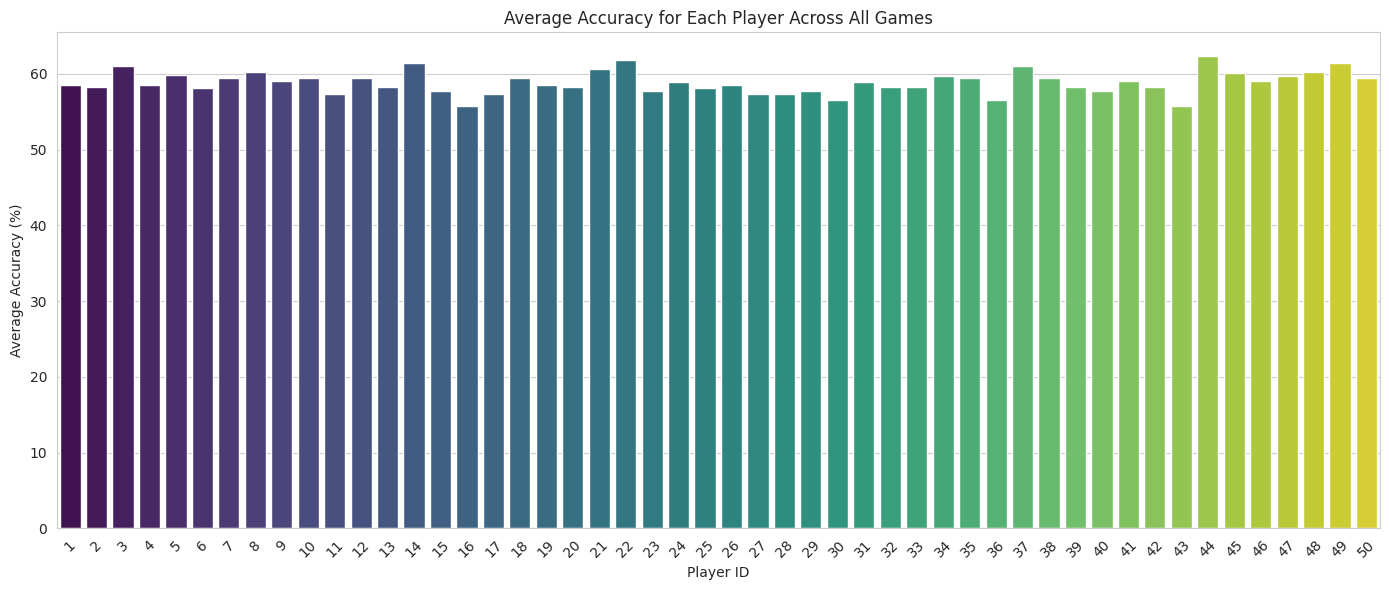

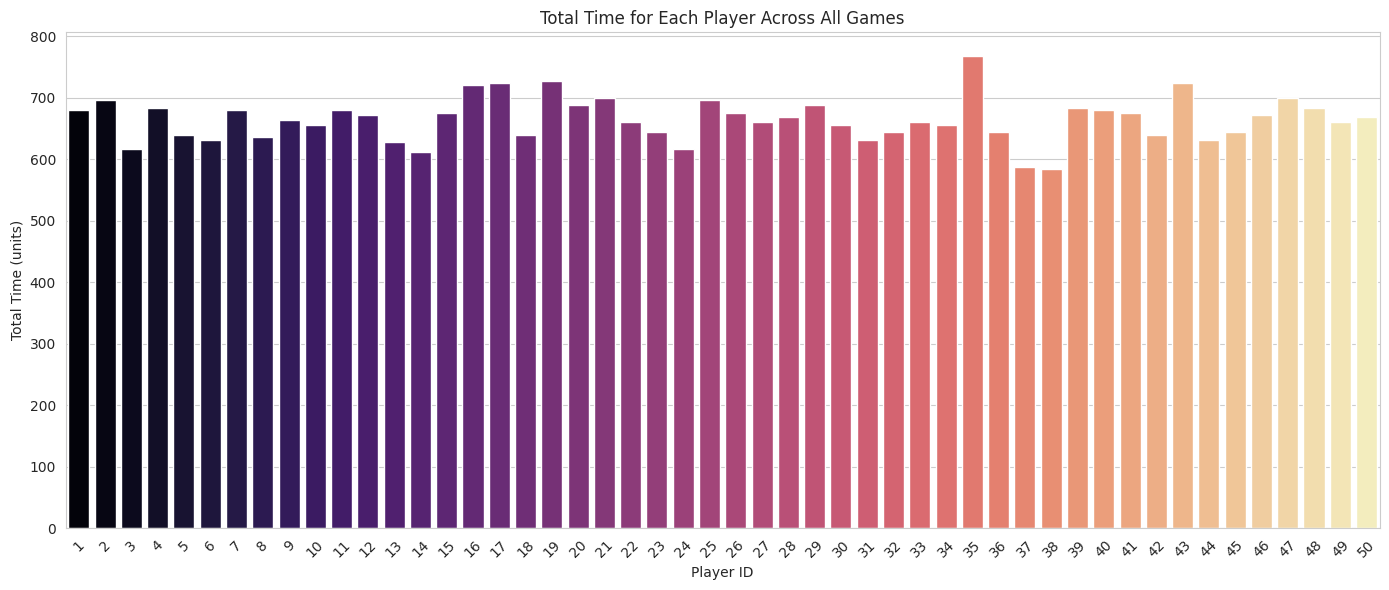

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine all dataframes
all_games = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Calculate aggregated metrics per player
player_metrics = all_games.groupby('PlayerID').agg(
    AverageAccuracy=('Accuracy', 'mean'),
    TotalTime=('TotalTime', 'sum')
).reset_index()

# Setting the style
sns.set_style("whitegrid")

# Plotting Average Accuracy for each player across all games
plt.figure(figsize=(14, 6))
sns.barplot(x='PlayerID', y='AverageAccuracy', data=player_metrics, palette="viridis")
plt.title('Average Accuracy for Each Player Across All Games')
plt.ylabel('Average Accuracy (%)')
plt.xlabel('Player ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting Total Time taken by each player across all games
plt.figure(figsize=(14, 6))
sns.barplot(x='PlayerID', y='TotalTime', data=player_metrics, palette="magma")
plt.title('Total Time for Each Player Across All Games')
plt.ylabel('Total Time (units)')
plt.xlabel('Player ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

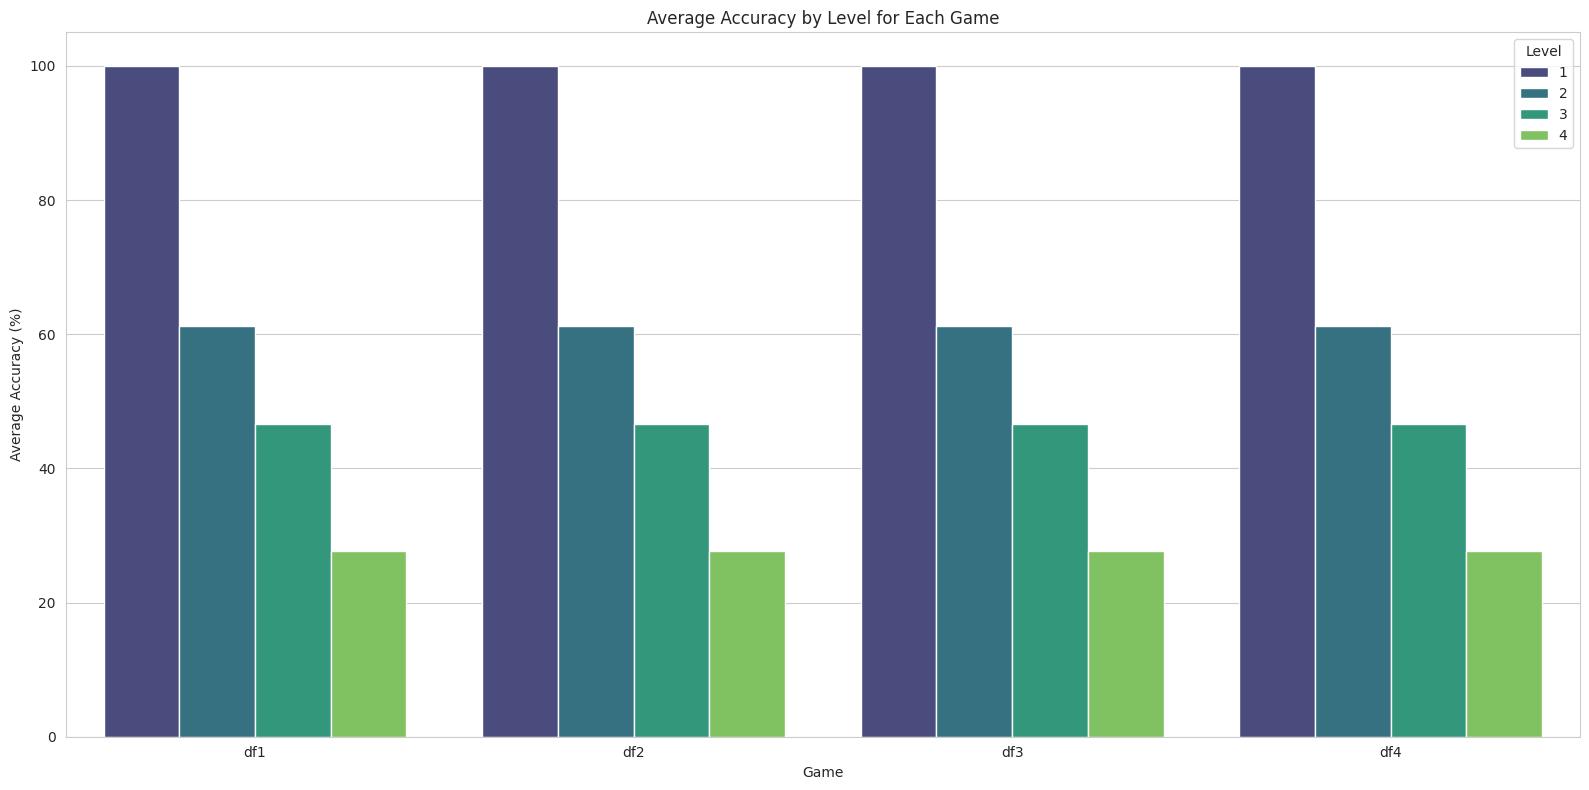

In [25]:
# Melt dataframes to get a long format
df1_melted = df1.melt(id_vars=["PlayerID", "Level", "Accuracy"], value_name="Game").assign(Game="df1")
df2_melted = df2.melt(id_vars=["PlayerID", "Level", "Accuracy"], value_name="Game").assign(Game="df2")
df3_melted = df3.melt(id_vars=["PlayerID", "Level", "Accuracy"], value_name="Game").assign(Game="df3")
df4_melted = df4.melt(id_vars=["PlayerID", "Level", "Accuracy"], value_name="Game").assign(Game="df4")

# Concatenate melted dataframes
all_games_melted = pd.concat([df1_melted, df2_melted, df3_melted, df4_melted])

# Group by Game and Level
game_level_metrics = all_games_melted.groupby(['Game', 'Level']).agg(
    AverageAccuracy=('Accuracy', 'mean')
).reset_index()

# Plotting
plt.figure(figsize=(16, 8))
sns.barplot(x="Game", y="AverageAccuracy", hue="Level", data=game_level_metrics, palette="viridis")
plt.title('Average Accuracy by Level for Each Game')
plt.ylabel('Average Accuracy (%)')
plt.xlabel('Game')
plt.legend(title="Level")
plt.tight_layout()
plt.show()